<a href="https://colab.research.google.com/github/dolmani38/drift/blob/main/Monitoring%20Data%20and%20Model%20Drift%20in%20your%20MLOps%20pipeline_%EC%88%98%EC%A0%953.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monitoring Data and Model Drift in your MLOps pipeline

https://www.persistent.com/blogs/monitoring-data-and-model-drift-in-your-mlops-pipeline/

https://docs.seldon.io/projects/alibi-detect/en/stable/index.html

Using plotly

https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point

In [1]:

if True:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/sj2503/drift-detection-project

Cloning into 'drift-detection-project'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 31 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (31/31), done.


# Installing and Importing Required Libraries:

In [3]:
!pip install mlflow
!pip install shap
!pip install evidently
!pip install alibi-detect

     |████████████████████████████████| 14.6 MB 4.9 MB/s 
     |████████████████████████████████| 79 kB 7.2 MB/s 
     |████████████████████████████████| 1.1 MB 38.4 MB/s 
     |████████████████████████████████| 636 kB 38.6 MB/s 
     |████████████████████████████████| 56 kB 4.3 MB/s 
     |████████████████████████████████| 170 kB 54.3 MB/s 
     |████████████████████████████████| 145 kB 54.4 MB/s 
     |████████████████████████████████| 75 kB 4.2 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for alembic: filename=alembic-1.4.1-py2.py3-none-any.whl size=158172 sha256=7d0b90d0c9c31db8a6fc8b2d352799f71840309bb15dd06a294b8176348204ed
  Stored in directory: /root/.cache/pip/wheels/be/5d/0a/9e13f53f4f5dfb67cd8d245bb7cdffe12f135846f491a283e3
  Created wheel for databricks-cli: filename=databricks_cli-0.15.0-py3-none-any.whl size=105260 sha256=534c5af33b87d4f651ac056ce2bfe407615e9a52f71af3d2fbab351b3109341

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.io.feather_format import read_feather
import seaborn as sns
import json
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from evidently.dashboard import Dashboard
from evidently.tabs import ClassificationPerformanceTab, DataDriftTab

import mlflow
import shap
import sys
from alibi_detect.cd import ChiSquareDrift, KSDrift

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [5]:
%cd /content/drift-detection-project/Loan Prediction Model

/content/drift-detection-project/Loan Prediction Model


# Defining mlfow_run Function:

In [244]:
from alibi_detect.cd import KSDrift

print()
# get the dataset name
p_dataset = 'data.csv'
p_model = sys.argv[4] if len(sys.argv) > 4 else 'RandomForestClassifier'
print()
print("Loading dataset %s ..."%p_dataset)

# ##### LOAD THE DATA #####
data1 = pd.read_csv(p_dataset)
data1



Loading dataset data.csv ...


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [277]:

print("Pre-processing & Cleansing...")
data = data1.drop(columns=['Loan_ID']) ## Dropping Loan ID
categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area','Credit_History','Loan_Amount_Term']
numerical_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
numerical_data = data[numerical_columns].copy()
categorical_data = data[categorical_columns].copy()
categorical_data["Gender"] = categorical_data["Gender"].map({"Male":1,"Female":0})
categorical_data["Married"] = categorical_data["Married"].map({"Yes":1,"No":0})
categorical_data["Dependents"] = categorical_data["Dependents"].map({"0":0,"1":1,"2":2,"3+":3})
categorical_data["Education"] = categorical_data["Education"].map({"Graduate":1, "Not Graduate":0})
categorical_data["Self_Employed"] = categorical_data["Self_Employed"].map({"Yes":1, "No":0})
categorical_data["Loan_Amount_Term"] = categorical_data["Loan_Amount_Term"].map({12:0,36:1,60:2,84:3,120:4,180:5,240:6,300:7,360:8,480:9})
categorical_data["Credit_History"] = categorical_data["Credit_History"].map({0.0:1,1.0:2,2.0:3,3.0:4})
categorical_data["Property_Area"] = categorical_data["Property_Area"].map({"Urban":2,"Semiurban":1, "Rural":0})
categorical_data = categorical_data.to_numpy().astype(int)


##### FEATURE ENGINEERING #####
print()
print("Feature Engineering...")
train_df_encoded = pd.get_dummies(data,drop_first=True)
X = train_df_encoded.drop(columns=['Loan_Status_Y'])
X_columns = X.columns
print(X_columns)
y = train_df_encoded['Loan_Status_Y']
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.25)
print(X_train)

Pre-processing & Cleansing...

Feature Engineering...
Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Gender_Male', 'Married_Yes',
       'Dependents_1', 'Dependents_2', 'Dependents_3+',
       'Education_Not Graduate', 'Self_Employed_Yes',
       'Property_Area_Semiurban', 'Property_Area_Urban'],
      dtype='object')
     ApplicantIncome  ...  Property_Area_Urban
150             6277  ...                    0
353             5500  ...                    0
365             6216  ...                    0
109             2071  ...                    0
422             1820  ...                    1
..               ...  ...                  ...
15              4950  ...                    1
32              4692  ...                    0
468              210  ...                    0
608             3232  ...                    0
274             3900  ...                    0

[460 rows x 14 columns]


In [237]:

def model_build(X_train,X_test,y_train,y_test, explanations = True):
    imp = SimpleImputer(strategy='mean')
    imp_train = imp.fit(X_train)
    X_train = imp_train.transform(X_train)
    X_test_tmp = X_test.copy()
    X_test = imp_train.transform(X_test)
    X_test_df = pd.DataFrame(X_test, columns=X_columns)
    #imp_numerical_data = imp.fit(numerical_data)
    #numerical_data = imp_numerical_data.transform(numerical_data)
    # ##### BUILD ML MODEL #####
    print()
    print("Building the ML Model...")
    model = RandomForestClassifier(n_estimators=50,max_depth=5)
    model.fit(X_train,y_train)
    # print(list(zip(train_df_encoded.columns, model.feature_importances_)))       
    # cross-validation
    xval_scores = cross_val_score(model, X_train, y_train, cv=10)   
    #print(xval_scores)
    # ##### METRICS #####
    print()
    print("Model evaluation...")
    y_pred = model.predict(X_train)
    train_f1 = f1_score(y_train,y_pred)
    train_acc = accuracy_score(y_train,y_pred)
    y_pred = model.predict(X_test)
    test_f1 = f1_score(y_test,y_pred)
    test_acc = accuracy_score(y_test,y_pred)
    print('--'*10)
    print('TRAINING ACCURACY', train_acc,'\n\tF1 score',train_f1)
    print('TESTING ACCURACY', test_acc,'\n\tF1 score',test_f1)
    print('--'*10)
    #print(X_test_tmp)
    if explanations:
        # ##### EXPLANATIONS #####
        print()
        print("Generating explanations...")
        plt.figure(figsize=(30,15))
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        shap.summary_plot(shap_values, X_test_tmp, show=False, class_names=['Rejected','Approved'])
        plt.savefig('SHAP_EXPLANATIONS.png', bbox_inches='tight')

    return model,X_train,X_test_df



Building the ML Model...

Model evaluation...
--------------------
TRAINING ACCURACY 0.841304347826087 
	F1 score 0.8995873452544705
TESTING ACCURACY 0.7597402597402597 
	F1 score 0.8310502283105022
--------------------

Generating explanations...


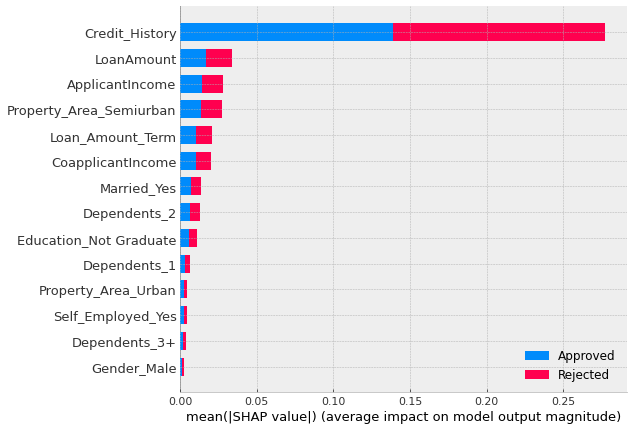

In [278]:

model,X_train,X_test_df = model_build(X_train,X_test,y_train,y_test)

In [279]:
import random

result_data = {}
result_data['model performance'] = []
for column in X_columns:
    result_data[column + ' KPI'] = []
    result_data[column + ' Drift'] = []
    result_data[column + ' p_val'] = []
drift_point = {} # feature_name:[(x,y),p_val]
report_files = []
epochs = 200

epsilon = 1 # Epsilon-greedy algorithm in initialized at 1 meaning every step is random at the start
max_epsilon = 1 # You can't explore more than 100% of the time
min_epsilon = 0.001 # At a minimum, we'll always explore 1% of the time
decay = 1/epochs

Trigger = True
# data drift detect...
cd = KSDrift(X_train, p_val=0.05)
step = 0

retrain_limit = 4
retrain_count = 0
while True:
    if step > epochs:
        break
    step += 1
    RG = 200000/step
    # ##### DRIFT GENERATOR DATASET ######
    #print()
    #print("Creating dataset with data drift...")
    X_test_df_old = X_test_df.copy()
    random_number = np.random.rand()
    for i in range(0,X_test_df.shape[0]):
            ApplicantIncome_Change = np.random.randint(-60,-20)
            LoanAmount_Change = np.random.randint(30,71)
            CoapplicantIncome_Change = np.random.randint(-60,-20)
            X_test_df.loc[i,"ApplicantIncome"] = (1 + (ApplicantIncome_Change/RG)) * X_test_df.loc[i,"ApplicantIncome"]
            if(X_test_df.loc[i,"CoapplicantIncome"]!=0):
                    X_test_df.loc[i,"CoapplicantIncome"] = (1 + (CoapplicantIncome_Change/RG)) * X_test_df.loc[i,"CoapplicantIncome"]
            X_test_df.loc[i,"LoanAmount"] = (1 + (LoanAmount_Change/RG)) * X_test_df.loc[i,"LoanAmount"]
            '''
            categorical_data["Gender"] = categorical_data["Gender"].map({"Male":1,"Female":0})
            categorical_data["Married"] = categorical_data["Married"].map({"Yes":1,"No":0})
            categorical_data["Dependents"] = categorical_data["Dependents"].map({"0":0,"1":1,"2":2,"3+":3})
            categorical_data["Education"] = categorical_data["Education"].map({"Graduate":1, "Not Graduate":0})
            categorical_data["Self_Employed"] = categorical_data["Self_Employed"].map({"Yes":1, "No":0})
            categorical_data["Loan_Amount_Term"] = categorical_data["Loan_Amount_Term"].map({12:0,36:1,60:2,84:3,120:4,180:5,240:6,300:7,360:8,480:9})
            categorical_data["Property_Area"] = categorical_data["Property_Area"].map({"Urban":2,"Semiurban":1, "Rural":0})
            '''
            
            # 2. Explore using the Epsilon Greedy Exploration Strategy
            if random_number <= epsilon:
                pass
            else:
                # Explore
                if np.random.rand() < 0.009:
                    X_test_df.loc[i,"Credit_History"] = 1 - X_test_df.loc[i,"Credit_History"]
            '''
                if random.choice([0,1]):
                    X_test_df.loc[i,"Gender_Male"] = 1 - X_test_df.loc[i,"Gender_Male"]
                if random.choice([0,1]):    
                    X_test_df.loc[i,"Married_Yes"] = 1 - X_test_df.loc[i,"Married_Yes"]
                if random.choice([0,1]):
                    c = random.choice([0,1,2,3])
                    X_test_df.loc[i,"Dependents_1"] = (1 if c == 1 else 0)
                    X_test_df.loc[i,"Dependents_2"] = (1 if c == 2 else 0)
                    X_test_df.loc[i,"Dependents_3+"] = (1 if c == 3 else 0)
                if random.choice([0,1]):
                    X_test_df.loc[i,"Education_Not Graduate"] = 1 - X_test_df.loc[i,"Education_Not Graduate"]
                X_test_df.loc[i,"Loan_Amount_Term"] = random.choice([0,1,2,3,4,5,6,7,8,9])
                if random.choice([0,1]):
                    c = random.choice([2,1,0])
                    X_test_df.loc[i,"Property_Area_Semiurban"] = (1 if c == 1 else 0)
                    X_test_df.loc[i,"Property_Area_Urban"] = (1 if c == 2 else 0)
            '''

    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * step)

    preds = cd.predict(X_test_df[X_columns].to_numpy(), drift_type='batch', return_p_val=True, return_distance=True)
    fpreds = cd.predict(X_test_df[X_columns].to_numpy(), drift_type='feature')
    for f in range(cd.n_features):
        stat = 'K-S'
        fname = X_columns[f]
        is_drift = fpreds['data']['is_drift'][f]
        stat_val, p_val = preds['data']['distance'][f], preds['data']['p_val'][f]
        #print(f'{fname}-- Drift? {[is_drift]} -- {stat} {stat_val:.3f} -- p-value {p_val:.5f}') 
        result_data[fname + ' KPI'].append(stat_val)
        result_data[fname + ' Drift'].append(is_drift)
        result_data[fname + ' p_val'].append(p_val)
        if is_drift and fname+str(retrain_count) not in drift_point:
            drift_point[fname+str(retrain_count)] = [(len(result_data[fname + ' KPI'])-1,stat_val),p_val]


    y_pred_datadrift = model.predict(X_test_df)
    datadrift_test_acc = accuracy_score(y_test,y_pred_datadrift)
    #print("Datadrift_Test_Accuracy: ",datadrift_test_acc)
    result_data['model performance'].append(datadrift_test_acc)

    print(f"\r {step+1}/{epochs} {epsilon} {result_data['ApplicantIncome Drift'][-1]}", end="", flush=True)

    if Trigger and result_data['Credit_History Drift'][-1] == 1 and result_data['ApplicantIncome Drift'][-1] == 1 and result_data['CoapplicantIncome Drift'][-1] == 1 and result_data['LoanAmount Drift'][-1] == 1:
        print('Trigger!!!')
        for fname in drift_point.keys():
            p,p_val = drift_point[fname]
            print('{} drift at {:.4f} with p_value {:.5f}'.format(fname,p[1],p_val))
        '''
        print("Generating data drift related reports...")
        loan_data_drift_report = Dashboard(tabs=[DataDriftTab])
        loan_data_drift_report.calculate(X_train, X_test_df, column_mapping=None)
        report_file_name = "loan_datadrift_oldone_"+str(retrain_count)+".html"
        loan_data_drift_report.save(report_file_name)
        report_files.append(report_file_name)
        '''
        Trigger = False
        if retrain_count < retrain_limit and True:
            X = np.concatenate([X_train,X_test_df.to_numpy()])
            y = np.concatenate([y_train,y_test])
            X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.25)
            model,X_train,X_test_df = model_build(X_train,X_test,y_train,y_test,explanations=False)
            cd = KSDrift(X_train, p_val=0.05)
            step = 0
            epsilon = 1
            retrain_count += 1
            Trigger = True
            if retrain_count == retrain_limit:
                step = epochs+1

result_df = pd.DataFrame(result_data)

#result_df.plot()
result_df

 43/200 0.8107736617242169 1Trigger!!!
LoanAmount0 drift at 0.1309 with p_value 0.03839
ApplicantIncome0 drift at 0.1267 with p_value 0.04930
CoapplicantIncome0 drift at 0.1296 with p_value 0.04137
Credit_History0 drift at 0.1355 with p_value 0.02898

Building the ML Model...

Model evaluation...
--------------------
TRAINING ACCURACY 0.841304347826087 
	F1 score 0.898186889818689
TESTING ACCURACY 0.7337662337662337 
	F1 score 0.8127853881278538
--------------------
 77/200 0.6841775478031434 1Trigger!!!
LoanAmount0 drift at 0.1309 with p_value 0.03839
ApplicantIncome0 drift at 0.1267 with p_value 0.04930
CoapplicantIncome0 drift at 0.1296 with p_value 0.04137
Credit_History0 drift at 0.1355 with p_value 0.02898
LoanAmount1 drift at 0.1320 with p_value 0.03591
ApplicantIncome1 drift at 0.1350 with p_value 0.02992
CoapplicantIncome1 drift at 0.1312 with p_value 0.03761
Credit_History1 drift at 0.1292 with p_value 0.04236

Building the ML Model...

Model evaluation...
-------------------

,model performance,ApplicantIncome KPI,ApplicantIncome Drift,ApplicantIncome p_val,CoapplicantIncome KPI,CoapplicantIncome Drift,CoapplicantIncome p_val,LoanAmount KPI,LoanAmount Drift,LoanAmount p_val,Loan_Amount_Term KPI,Loan_Amount_Term Drift,Loan_Amount_Term p_val,Credit_History KPI,Credit_History Drift,Credit_History p_val,Gender_Male KPI,Gender_Male Drift,Gender_Male p_val,Married_Yes KPI,Married_Yes Drift,Married_Yes p_val,Dependents_1 KPI,Dependents_1 Drift,Dependents_1 p_val,Dependents_2 KPI,Dependents_2 Drift,Dependents_2 p_val,Dependents_3+ KPI,Dependents_3+ Drift,Dependents_3+ p_val,Education_Not Graduate KPI,Education_Not Graduate Drift,Education_Not Graduate p_val,Self_Employed_Yes KPI,Self_Employed_Yes Drift,Self_Employed_Yes p_val,Property_Area_Semiurban KPI,Property_Area_Semiurban Drift,Property_Area_Semiurban p_val,Property_Area_Urban KPI,Property_Area_Urban Drift,Property_Area_Urban p_val
0,0.759740,0.098278,0,2.150684e-01,0.066968,0,6.788817e-01,0.079193,0,4.643665e-01,0.028684,0,0.999982,0.070525,0,0.614508,0.040288,0,0.992024,0.024478,0,1.000000,0.005054,0,1.00000,0.023123,0,1.0,0.001807,0,1.0,0.005280,0,1.0,0.012422,0,1.0,0.021146,0,1.00000,0.06358,0,0.739435
1,0.759740,0.098278,0,2.150684e-01,0.066968,0,6.788817e-01,0.079193,0,4.643665e-01,0.028684,0,0.999982,0.070525,0,0.614508,0.040288,0,0.992024,0.024478,0,1.000000,0.005054,0,1.00000,0.023123,0,1.0,0.001807,0,1.0,0.005280,0,1.0,0.012422,0,1.0,0.021146,0,1.00000,0.06358,0,0.739435
2,0.759740,0.098278,0,2.150684e-01,0.066968,0,6.788817e-01,0.079193,0,4.643665e-01,0.028684,0,0.999982,0.070525,0,0.614508,0.040288,0,0.992024,0.024478,0,1.000000,0.005054,0,1.00000,0.023123,0,1.0,0.001807,0,1.0,0.005280,0,1.0,0.012422,0,1.0,0.021146,0,1.00000,0.06358,0,0.739435
3,0.759740,0.098278,0,2.150684e-01,0.066968,0,6.788817e-01,0.079193,0,4.643665e-01,0.028684,0,0.999982,0.070525,0,0.614508,0.040288,0,0.992024,0.024478,0,1.000000,0.005054,0,1.00000,0.023123,0,1.0,0.001807,0,1.0,0.005280,0,1.0,0.012422,0,1.0,0.021146,0,1.00000,0.06358,0,0.739435
4,0.759740,0.096104,0,2.369950e-01,0.069142,0,6.395187e-01,0.079193,0,4.643665e-01,0.028684,0,0.999982,0.070525,0,0.614508,0.040288,0,0.992024,0.024478,0,1.000000,0.005054,0,1.00000,0.023123,0,1.0,0.001807,0,1.0,0.005280,0,1.0,0.012422,0,1.0,0.021146,0,1.00000,0.06358,0,0.739435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,0.694805,0.609317,1,1.245148e-37,0.370073,1,3.770620e-14,0.661293,1,2.942727e-44,0.027555,0,0.999994,0.120271,0,0.071026,0.031621,0,0.999833,0.059147,0,0.814363,0.046951,0,0.96112,0.005788,0,1.0,0.024195,0,1.0,0.012055,0,1.0,0.003755,0,1.0,0.039526,0,0.99371,0.02891,0,0.999978
328,0.701299,0.615839,1,1.970172e-38,0.372247,1,2.598333e-14,0.665669,1,8.407791e-45,0.027555,0,0.999994,0.120271,0,0.071026,0.031621,0,0.999833,0.059147,0,0.814363,0.046951,0,0.96112,0.005788,0,1.0,0.024195,0,1.0,0.012055,0,1.0,0.003755,0,1.0,0.039526,0,0.99371,0.02891,0,0.999978
329,0.694805,0.631056,1,2.471792e-40,0.378741,1,8.433367e-15,0.676539,1,0.000000e+00,0.027555,0,0.999994,0.120271,0,0.071026,0.031621,0,0.999833,0.059147,0,0.814363,0.046951,0,0.96112,0.005788,0,1.0,0.024195,0,1.0,0.012055,0,1.0,0.003755,0,1.0,0.039526,0,0.99371,0.02891,0,0.999978
330,0.701299,0.635404,1,6.937548e-41,0.385234,1,2.684455e-15,0.683032,1,0.000000e+00,0.027555,0,0.999994,0.120271,0,0.071026,0.031621,0,0.999833,0.059147,0,0.814363,0.046951,0,0.96112,0.005788,0,1.0,0.024195,0,1.0,0.012055,0,1.0,0.003755,0,1.0,0.039526,0,0.99371,0.02891,0,0.999978


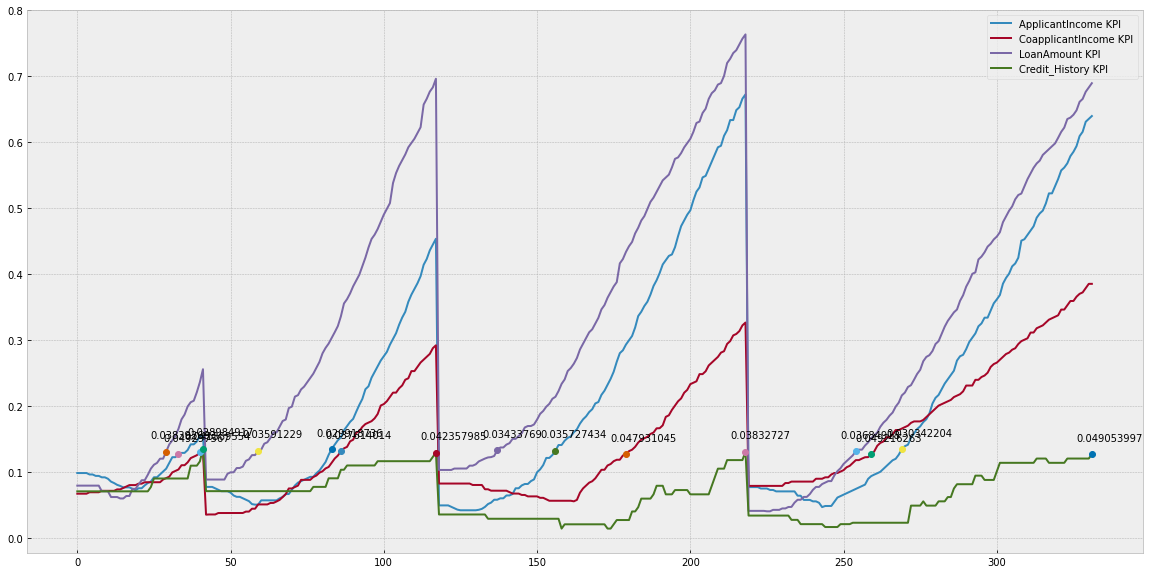

'\nfor html_file in report_files:\n    display(IPython.display.HTML(filename="/content/drift-detection-project/Loan Prediction Model/" + html_file))\n'

In [280]:
import IPython

# Bayesian Methods for Hackers style sheet
plt.style.use('bmh')
result_df[['ApplicantIncome KPI','CoapplicantIncome KPI','LoanAmount KPI','Credit_History KPI']].plot(figsize=(20,10))

for fname in drift_point.keys():
    p,p_val = drift_point[fname]
    plt.annotate(str(p_val), (p[0]-5,p[1]+0.02))
    plt.plot([p[0]],[p[1]],'o')

plt.show()
'''
for html_file in report_files:
    display(IPython.display.HTML(filename="/content/drift-detection-project/Loan Prediction Model/" + html_file))
'''

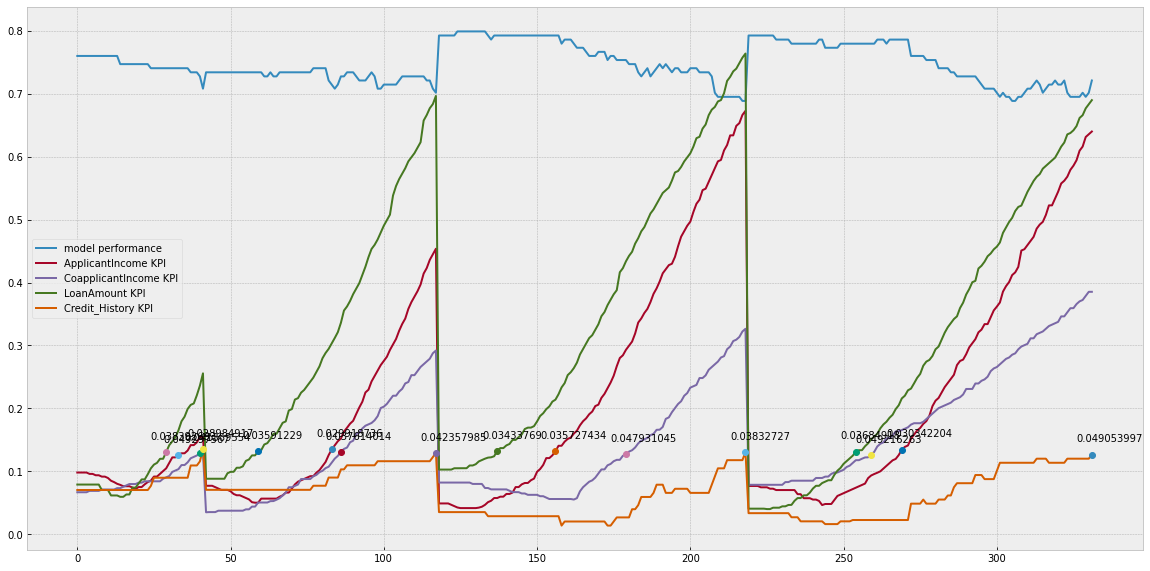

In [281]:

result_df[['model performance','ApplicantIncome KPI','CoapplicantIncome KPI','LoanAmount KPI','Credit_History KPI']].plot(figsize=(20,10))

for fname in drift_point.keys():
    p,p_val = drift_point[fname]
    plt.annotate(str(p_val), (p[0]-5,p[1]+0.02))
    plt.plot([p[0]],[p[1]],'o')